## 프로젝트: 더 멋진 번역기 만들기

### Step. 데이터 정제 및 토큰화

set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다.

데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.


In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm    # Process 과정을 보기 위해
import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


In [53]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [54]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    """
     - 텍스트 파일 로드
     - set 활용 중복 데이터 제거
    """
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    #중복 데이터 제거
    raw = zip(kor, eng)
    cleaned_corpus = set(raw)



    return cleaned_corpus

In [55]:
# 데이터 정제
def preprocess_sentence(sentence):
    """
    - 모든 입력을 소문자로 변환합니다.
    - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    - 문장부호 양옆에 공백을 추가합니다.
    - 문장 앞뒤 불필요한 공백을 제거합니다.
    """
    sentence = sentence.lower().strip()

#     sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
#     sentence = re.sub(r'[" "]+', " ", sentence)
    
    sentence = re.sub(r'([?.!,])]', r'w1', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'[^a-zA-Z?.!,가-힣ㄱ-ㅎㅏ-ㅣ0-9]', " ",sentence)

    sentence = sentence.strip()
    
    return sentence

In [63]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
#     txt = f"--input={corpus} --model_prefix={lang} --vocab_size={vocab_size + 7}"
#     txt +=" --model_type=bpe"
#     txt +=" --max_sentence_length=999999" # 문장 최대 길이 (너무 길면 에러발생)
#     txt +=f" --pad_id={pad_id} --pad_piece=<pad>" # pad (0)
#     txt +=f" --unk_id={unk_id} --unk_piece=<unk>" # unknown (1)
#     txt +=f" --bos_id={bos_id} --bos_piece=<s>" # begin of sequence (2)
#     txt +=f" --eos_id={eos_id} --eos_piece=</s>"
#     print(txt)
    
    spm.SentencePieceTrainer.Train(f'--input={corpus} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id} \
                                    --model_prefix={lang} --vocab_size={SRC_VOCAB_SIZE}')
    
    sp = spm.SentencePieceProcessor()
    sp.load(f'{lang}.model')
    return sp

In [57]:
# 데이터 로드 및 정제
cleaned_corpus = clean_corpus(kor_path, eng_path)

In [58]:
# 데이터 분리
kor_corpus = []
eng_corpus = []

for ko, en in (cleaned_corpus):
    kor_corpus.append(preprocess_sentence(ko))
    eng_corpus.append(preprocess_sentence(en))

In [59]:
print("한글:", kor_corpus[:5]) 
print("")
print("영어:", eng_corpus[:5])

한글: ['아메리칸 뷰티,     외로운 스타   등에서 명성을 날린 노련한 성격배우 쿠퍼는 작가 수전 올린의   난초 도둑  을 대충 토대로 삼은 영화에서 희귀종 난을 보존하는 임무를 띤 남자 역을 맡았다.', '후세인의 묘지는 이라크 국기와 및 조화로 둘러싸였으며 묘지 앞에는 후세인의 사진이 걸렸다.', 'ms 프로젝트 매니저인 샤로트 존스는  윈도우 7은 데스크탑에서 윈도우 간에 쉽게 이동 가능하다 고 설명했다. 그는 홀에 마련된 대형 디스플레이 화면에서 간단한 시범을 보였다.', '파이야즈바크슈 원자력청 위원장은 원전 1곳을 건설하는데 11년이 걸리며 27억 달러의 비용이 필요하다고 지적했다.', '유엔 대변인도 이날 반기문 유엔 사무총장이 미얀마 구호 속도를 가속화하기 위해 미얀마를 방문할 예정이라고 밝혔다.']

영어: ['cooper, a veteran character actor whose credits include   american beauty   and   lone star,   played a man on a mission to preserve rare orchids in the film loosely based on author susan orlean s   the orchid thief.', 'the tomb was covered in iraqi flags and flowers and flanked by large pictures of a smiling hussein.', 'windows 7 makes it easier to move between the things on your desktop, said microsoft group project manager charlotte jones, who gave a brief demonstration of the system on the hall s giant display screens.', 'each plant would cost up to  1.7 billion and take up

In [60]:
# 전처리된 문장 저장
with open('train.ko.txt', 'w', encoding='utf8') as f:
    for sentence in kor_corpus:
        f.write(sentence + "\n")
with open('train.en.txt', 'w', encoding='utf8') as f:
    for sentence in eng_corpus:
        f.write(sentence + "\n")

In [64]:
#센텐스피스 훈련
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000
ko_tokenizer = generate_tokenizer("train.ko.txt", SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer("train.en.txt", TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [65]:
#토큰 데이터 확인
print(ko_tokenizer.encode_as_pieces(kor_corpus[0]))
print(ko_tokenizer.encode_as_ids(kor_corpus[0]))
print(len(ko_tokenizer))

['▁아메리칸', '▁뷰', '티', ',', '▁외', '로운', '▁스타', '▁등', '에서', '▁명성', '을', '▁날', '린', '▁노', '련', '한', '▁성격', '배우', '▁쿠퍼', '는', '▁작가', '▁수', '전', '▁올린', '의', '▁난', '초', '▁도둑', '▁', '을', '▁대', '충', '▁토대', '로', '▁삼', '은', '▁영화에서', '▁희귀', '종', '▁난', '을', '▁보존', '하는', '▁임무', '를', '▁', '띤', '▁남자', '▁역', '을', '▁맡았다', '.']
[4006, 13413, 399, 12, 742, 3481, 1226, 93, 16, 6057, 5, 658, 465, 394, 4432, 17, 4689, 10415, 5279, 9, 2374, 27, 324, 3594, 6, 1112, 1135, 13679, 7, 5, 351, 5047, 6624, 18, 2603, 10, 6973, 12678, 741, 1112, 5, 4991, 40, 1375, 8, 7, 13120, 613, 2780, 5, 6420, 4]
20000


In [66]:
#토큰 데이터 확인
print(en_tokenizer.encode_as_pieces(eng_corpus[0]))
print(en_tokenizer.encode_as_ids(eng_corpus[0]))
print(len(en_tokenizer))

['<s>', '▁cooper', ',', '▁a', '▁veteran', '▁character', '▁actor', '▁whose', '▁credits', '▁include', '▁american', '▁beauty', '▁and', '▁lone', '▁star', ',', '▁played', '▁a', '▁man', '▁on', '▁a', '▁mission', '▁to', '▁preserve', '▁rare', '▁orchid', 's', '▁in', '▁the', '▁film', '▁loose', 'ly', '▁based', '▁on', '▁author', '▁susan', '▁or', 'le', 'an', '▁s', '▁the', '▁orchid', '▁thief', '.', '</s>']
[1, 5429, 6, 9, 3793, 3230, 1578, 721, 6853, 839, 208, 3915, 11, 1889, 480, 6, 1086, 9, 185, 17, 9, 755, 7, 5930, 1318, 17162, 13, 10, 4, 511, 6210, 65, 334, 17, 1989, 6116, 66, 1091, 674, 12, 4, 17162, 18662, 5, 2]
20000


In [67]:
#토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축
#텐서 enc_train 과 dec_train 으로 변환

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)


# 토큰의 길이가 50 이하인 문장만 남깁니다. 
max_token_length = 50
for idx in tqdm(range(len(kor_corpus))):
    ko_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if (len(ko_tokens) <= max_token_length) and len(en_tokens) <= max_token_length:
        src_corpus.append(ko_tokens)
        tgt_corpus.append(en_tokens)
    
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')


  0%|          | 0/78968 [00:00<?, ?it/s]

In [68]:
print(len(enc_train))
enc_train[0]

74432


array([ 1486,     6,  7978,     9,    74,  5526,    26,     7,   157,
       11632,    18,  4323,  2974,  7978,  3926,     9,  1486,     6,
        6254,  6967,     4,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [69]:
print(len(dec_train))
dec_train[0]

74432


array([    1,     4,  4540,    20,  2556,    10,   267,  4195,    11,
        6829,    11, 10898,    21,    28,   501,  2041,     8,     9,
        6950,  1930,     5,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

###  Step. 모델 설계

### 내부 모듈 구현하기
- 입력 데이터 → [ batch_size x length ]
- Source & Target Embedding → [ batch_size x length x d_emb ]
- Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
- Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.
  - Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]
  - Masking for Masked Attention
  - Scaled Dot Product Attention
  - Combine Heads →[ batch_size x length x d_emb ]
- Residual Connection
- Layer Normalization
- Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]
- Output Linear Layer → [ batch_size x length x vocab_size ]

### Positional Encoding
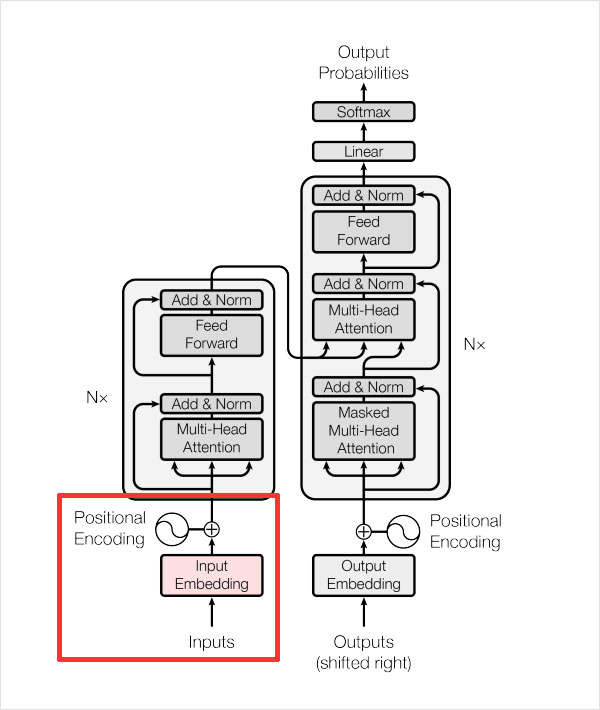

In [70]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


### Multi-Head Attention
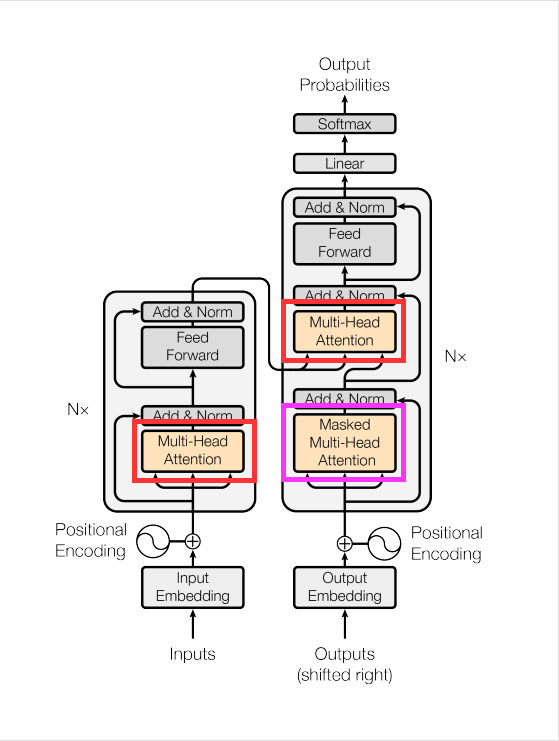

- Embedding된 입력을 Head 수로 분할하는 split_heads()
- 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention()
- 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads()

In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### Position-wise Feed-Forward Network

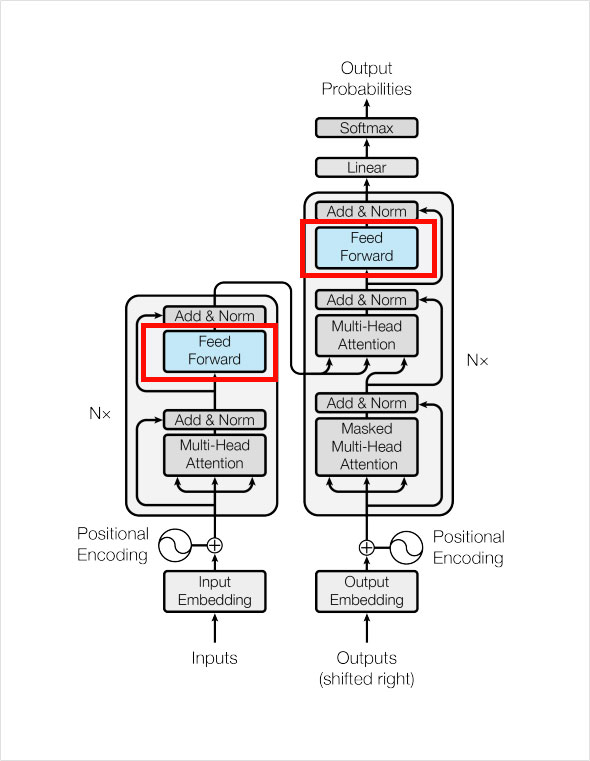

In [30]:
"""
d_ff 는 논문의 설명대로라면 2048 일 거고,
 d_model 은 512 겠죠? [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고
 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정까지! 이렇게 쉽게 FFN 완성
"""
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### 모듈 조립하기
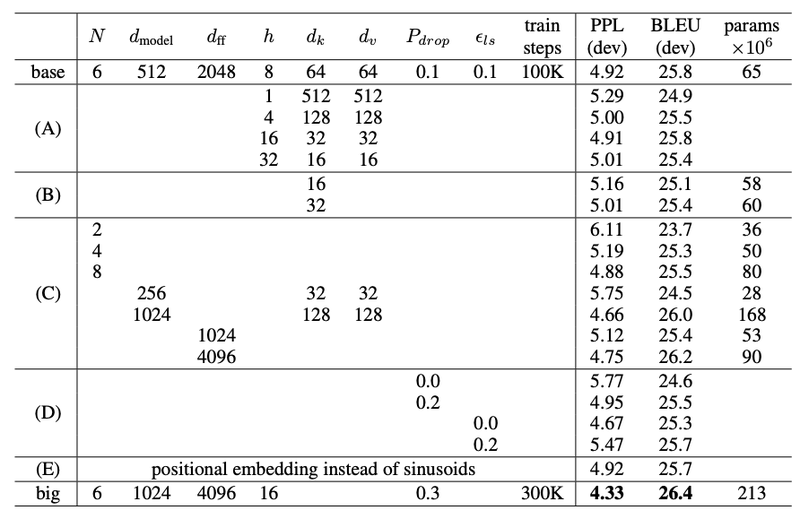

### Encoder 레이어 구현하기

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### Decoder 레이어 구현하기

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

print("슝=3")

슝=3


In [33]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [34]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### Transformer 완성하기

In [49]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        #1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        #2. Positional Encoding 정의
        self.pos_enc = positional_encoding(pos_len, d_model)

        #3. Encoder / Decoder 정의
        self.encoder = Encoder(
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout)
        self.decoder = Decoder(
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout)
        #4. Output Linear 정의
        self.out_lenear = tf.keras.layers.Dense(tgt_vocab_size)

        #5. Shared Weights
        self.shared = shared
        if shared: self.out_lenear.set_weights(tf.transpose(self.dec_emb.weights))

        #6. Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)


    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """

        # 0번지는 배치 크기
        # 1번지는 시퀀스 길이
        seq_len = x.shape[1] 
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_enc[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        

        logits = self.out_lenear(dec_out)


        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### 모델 밖의 조력자들

In [36]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


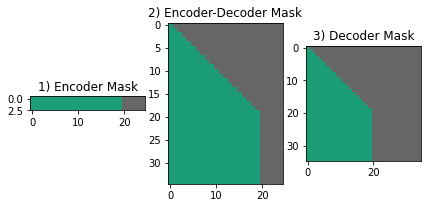

In [37]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [38]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)



print("슝=3")

슝=3


### Step . 훈련하기

하이퍼파라미터 정의 및 모델 정의

#### 손실 함수 

In [ ]:

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

####  Train Step 함수 정의

In [42]:

#@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [43]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [44]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [45]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

#### 하이퍼파라미터 정의 및 모델 초기화

In [71]:
# 모델 초기화
# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율
POS_LEN=200

transformer = Transformer(
    n_layers= NUM_LAYERS,
    d_model= D_MODEL,
    n_heads= NUM_HEADS,
    d_ff= UNITS,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=POS_LEN
)

In [40]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [41]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [ ]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president barack obama s president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a big city.
Input: 커피는 필요 없다.
Predicted translation: it s not really really a very difficult.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll is killed in the deaths of the deaths of the deaths.


  0%|          | 0/1163 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s going to be a president.
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of cities.
Input: 커피는 필요 없다.
Predicted translation: it s not a good thing.
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the deaths.


  0%|          | 0/1163 [00:00<?, ?it/s]